In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from holoanalytics import definitions as df
from holoanalytics.utils import importing
from holoanalytics.datapreparation import reformatting as reform
from holoanalytics.datavisualization import formatting as format

In [ ]:
importing.open_session(importing.request_session())

In [3]:
member_data = importing.import_member_data()
member_channel_data = importing.import_channel_data()
member_video_data = importing.import_video_data()
member_video_data = reform.reformat_datetimes(None, member_video_data)

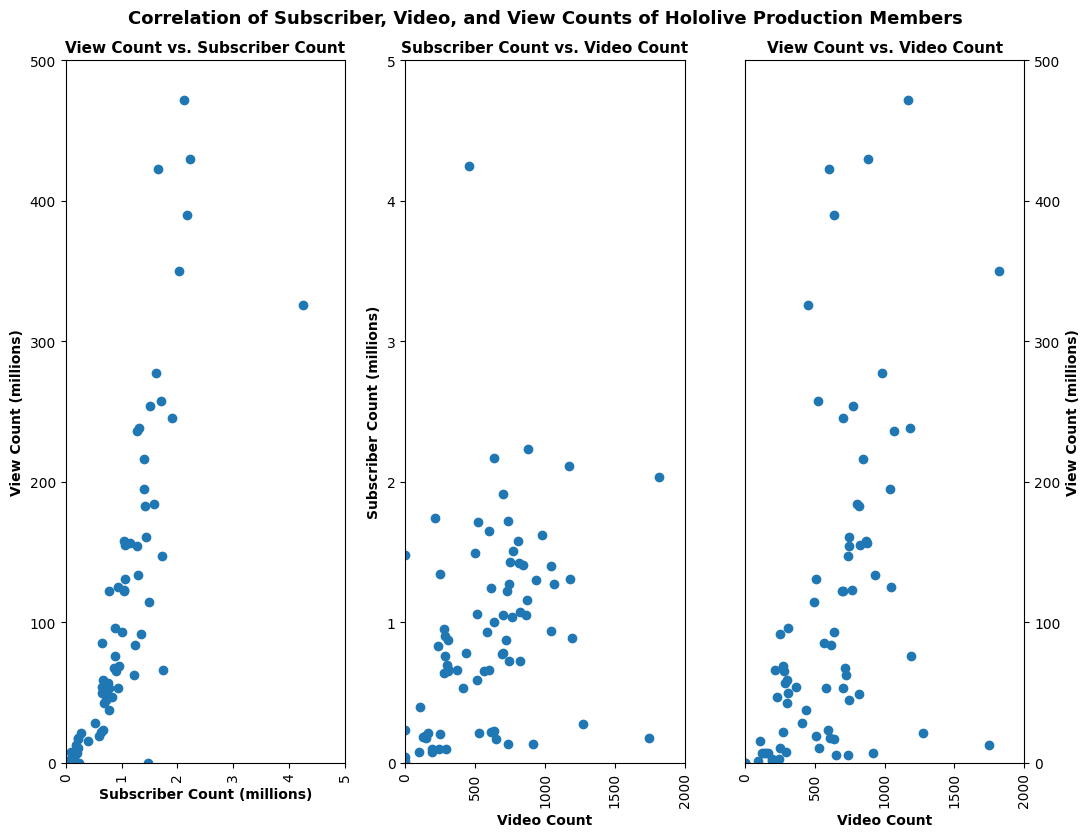

In [5]:
title_size = 11
title_weight = 'bold'
label_weight='bold'
scale = 1_000_000

data = member_data.merge(member_channel_data['channel_stats'], left_on='youtube_channel_id', right_on='channel_id')
max_y_value = data['view_count'].max()

fig, axes = plt.subplots(1, 3)
fig.set_size_inches(11, 8.5)

axes[0].scatter(x=data['subscriber_count']/scale, y=data['view_count']/scale)
axes[0].set_xlabel('Subscriber Count (millions)', fontweight=label_weight)
axes[0].set_ylabel('View Count (millions)', fontweight=label_weight)
axes[0].set_title('View Count vs. Subscriber Count', fontsize=title_size, fontweight=title_weight)
format.set_upper_limits(axes[0], max_x=data['subscriber_count'].max()/scale, max_y=data['view_count'].max()/scale)


axes[1].scatter(x=data['video_count'], y=data['subscriber_count']/scale)
axes[1].set_xlabel('Video Count', fontweight=label_weight)
axes[1].set_ylabel('Subscriber Count (millions)', fontweight=label_weight)
axes[1].set_title('Subscriber Count vs. Video Count', fontsize=title_size, fontweight=title_weight)
format.set_upper_limits(axes[1], max_x=data['video_count'].max(), max_y=data['subscriber_count'].max()/scale)

axes[2].scatter(x=data['video_count'], y=data['view_count']/scale)
axes[2].set_xlabel('Video Count', fontweight=label_weight)
axes[2].set_ylabel('View Count (millions)', fontweight=label_weight)
axes[2].set_title('View Count vs. Video Count', fontsize=title_size, fontweight=title_weight)
axes[2].yaxis.set_label_position('right')
axes[2].yaxis.tick_right()
format.set_upper_limits(axes[2], max_x=data['video_count'].max(), max_y=data['view_count'].max()/scale)

for index, _ in enumerate(axes):
    axes[index].get_xaxis().get_major_formatter().set_scientific(False)
    axes[index].get_yaxis().get_major_formatter().set_scientific(False)
    axes[index].tick_params(axis='x', rotation=90)
    axes[index].set_xlim(0)
    axes[index].set_ylim(0)

fig.suptitle('Correlation of Subscriber, Video, and View Counts of Hololive Production Members', 
             fontsize=13, fontweight=title_weight)
fig.tight_layout()

plt.show()